In [19]:
%%capture

import os
import math
import copy
import time
import warnings
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output, Markdown
from gridworld_pa1 import GridWorld, row_col_to_seq, seq_to_col_row

warnings.filterwarnings('ignore')
%matplotlib inline

In [20]:
# Random Seed
np.random.seed(87+122)

## Global Invariants

In [21]:
# Global Constants
num_episodes = 5000
num_runs = 5
max_steps = 100

## Environment

In [22]:
def init_env(start_state, p_good_transition, bias, wind):

    num_cols = 10
    num_rows = 10
    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
    restart_states = np.array([[3,7],[8,2]])
    start_state = np.array([start_state])
    goal_states = np.array([[0,9],[2,2],[8,7]])
    
    gw = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=start_state,
                goal_states=goal_states, wind = wind)
    gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=p_good_transition,
                                bias=bias)
    env = gw.create_gridworld()
    return env

## Policy

### (a) softmax

In [23]:
def softmax(Q, tau):
    Q = Q - np.max(Q)
    p = np.exp(Q/tau) / np.sum(np.exp(Q/tau))
    return np.random.choice(len(Q), p=p)


### (b) $\epsilon -$ greedy

In [24]:
def epsilon_greedy(Q, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(len(Q))
    else:
        return np.argmax(Q)

## Algorithm

In [25]:
class TDQLearner:
    def __init__(self, env, alpha, gamma, epsilon, tau, num_episodes, num_runs, policy='softmax'):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.tau = tau
        self.num_episodes = num_episodes
        self.num_runs = num_runs
        self.policy = policy

    def _choose_action(self, Q):
        if self.policy == 'softmax':
            return softmax(Q, self.tau)
        elif self.policy == 'epsilon_greedy':
            return epsilon_greedy(Q, self.epsilon)
        else:
            raise Exception("Policy not recognized")
    
    def train(self):
        pass


### (a) SARSA

\begin{equation*}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
\end{equation*}

In [26]:
class SARSA(TDQLearner):
    def train(self):
        rewards = np.zeros((self.num_runs, self.num_episodes))
        steps = np.zeros((self.num_runs, self.num_episodes))
        avg_Q = np.zeros((self.env.num_states, self.env.num_actions))
        state_visits = np.zeros((self.env.num_states, 1))

        for run in range(self.num_runs):
            Q = np.zeros((self.env.num_states, self.env.num_actions))
            for episode in tqdm(range(self.num_episodes), desc="Run:"+str(run+1), position=1):
                state = self.env.reset()
                state_visits[state] += 1
                done = False
                action = self._choose_action(Q[state, :])
                while not done:
                    next_state, reward = self.env.step(state, action)
                    next_action = self._choose_action(Q[next_state, :])

                    Q[state, action] += self.alpha * (reward + self.gamma * Q[next_state, next_action] - Q[state, action])

                    state = next_state
                    action = next_action
                    rewards[run, episode] += reward
                    steps[run, episode] += 1
                    state_visits[state] += 1
                    if state in self.env.goal_states_seq:
                        done = True
                    if steps[run, episode] > max_steps:
                        done = True
            avg_Q += Q

        avg_Q /= self.num_runs
        state_visits /= self.num_runs
        return avg_Q, rewards, steps, state_visits


### (b) Q-Learning

\begin{equation*}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]
\end{equation*}

In [27]:
class QLearning(TDQLearner):
    def train(self):
        rewards = np.zeros((self.num_runs, self.num_episodes))
        steps = np.zeros((self.num_runs, self.num_episodes))
        avg_Q = np.zeros((self.env.num_states, self.env.num_actions))
        state_visits = np.zeros((self.env.num_states, 1))

        for run in range(self.num_runs):
            Q = np.zeros((self.env.num_states, self.env.num_actions))
            for episode in tqdm(range(self.num_episodes), desc="Run:"+str(run+1), position=1):
                state = self.env.reset()
                state_visits[state] += 1
                done = False
                while not done:
                    action = self._choose_action(Q[state, :])
                    next_state, reward = self.env.step(state, action)

                    Q[state, action] += self.alpha * (reward + self.gamma * np.max(Q[next_state, :]) - Q[state, action])

                    state = next_state
                    rewards[run, episode] += reward
                    steps[run, episode] += 1
                    state_visits[state] += 1
                    if state in self.env.goal_states_seq:
                        done = True
                    if steps[run, episode] > max_steps:
                        done = True
            avg_Q += Q

        avg_Q /= self.num_runs
        state_visits /= self.num_runs
        return avg_Q, rewards, steps, state_visits


### (c) Optimal Policy

In [28]:
class OptimalPolicy:
    # Greedy policy based on Q values
    # returns the optimal_path and reward

    def __init__(self, env, Q):
        self.env = env
        self.Q = Q
        
    # def run(self):
    #     optimal_actions = np.argmax(self.Q, axis=1)
    #     state = self.env.start_state_seq.item()
    #     path = [state]
    #     reward = 0
    #     while state not in self.env.goal_states_seq and len(path) < max_steps:
    #         action = optimal_actions[state]
    #         if action == 0:
    #             state -= self.env.num_cols
    #         elif action == 1:
    #             state += self.env.num_cols
    #         elif action == 2:
    #             state -= 1
    #         elif action == 3:
    #             state += 1

    #         path.append(state)
    #         reward += self.env.R[state]
    #     return path, reward
        
    def run(self):
        state = self.env.start_state_seq.item()
        path = [state]
        reward = 0
        while state not in self.env.goal_states_seq and len(path) < max_steps:
            action = np.argmax(self.Q[state, :])
            if action == 0:
                next_state = state - self.env.num_cols
            elif action == 1:
                next_state = state + self.env.num_cols
            elif action == 2:
                next_state = state - 1
            elif action == 3:
                next_state = state + 1

            # if optimal action leads to an obstruction/restart state, choose the next best action
            Q = copy.deepcopy(self.Q[state, :])
            while next_state in row_col_to_seq(self.env.obs_states, self.env.num_cols) or next_state in row_col_to_seq(self.env.restart_states, self.env.num_cols):
                Q[action] = -np.inf
                action = np.argmax(Q)
                if action == 0:
                    next_state = state - self.env.num_cols
                elif action == 1:
                    next_state = state + self.env.num_cols
                elif action == 2:
                    next_state = state - 1
                elif action == 3:
                    next_state = state + 1

            path.append(next_state)
            reward += self.env.R[next_state]
            state = next_state
        return path, reward
    
    def path(self):
        return self.run()[0]

    def reward(self):
        return self.run()[1]


## Plot

In [29]:
class Plot():
    def __init__(self, env, rewards, steps, state_visits, Q, save=False, exp=None):
        self.env = env
        self.rewards = rewards
        self.steps = steps
        self.state_visits = state_visits
        self.Q = Q
        self.save = save
        self.exp = exp #Experiment number

    def reward(self):
        mean_rewards = np.mean(self.rewards, axis=0)
        std_rewards = np.std(self.rewards, axis=0)
        plt.figure(figsize=(10, 6))
        plt.plot(mean_rewards, label="Mean Reward", color='blue')
        plt.fill_between(range(len(mean_rewards)), mean_rewards-std_rewards, mean_rewards+std_rewards, alpha=0.3, color='blue')
        plt.xlabel("Episodes", fontsize=18)
        plt.ylabel("Reward", fontsize=18)
        plt.title("Reward Curve", fontsize=24)
        plt.legend(fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        if self.save:
            os.makedirs(f"images/{self.exp}", exist_ok=True)
            plt.savefig(f"images/{self.exp}/reward.pdf", format='pdf')
        plt.show()
            

    def steps_to_goal(self):
        mean_steps = np.mean(self.steps, axis=0)
        std_steps = np.std(self.steps, axis=0)
        plt.figure(figsize=(10, 6))
        plt.plot(mean_steps, label="Mean Steps", color='red')
        plt.fill_between(range(len(mean_steps)), mean_steps-std_steps, mean_steps+std_steps, alpha=0.3, color='red')
        plt.xlabel("Episodes", fontsize=18)
        plt.ylabel("Steps", fontsize=18)
        plt.title("Steps to reach the goal", fontsize=24)
        plt.legend(fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        if self.save:
            plt.savefig(f"images/{self.exp}/steps.pdf", format='pdf')
        plt.show()

    def state_visit_count(self):
        state_visits = np.sum(self.state_visits, axis=1)
        plt.figure(figsize=(10,10))
        plt.imshow(state_visits.reshape(self.env.num_rows, self.env.num_cols), cmap='jet')
        plt.title("State Visits", fontsize=24)
        plt.colorbar(shrink=0.825).ax.tick_params(labelsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        if self.save:
            plt.savefig(f"images/{self.exp}/state_visits.pdf", format='pdf')
        plt.show()

    def Q_values(self):
        optimal_actions = np.argmax(self.Q, axis=1)
        
        plt.figure(figsize=(10,10))
        # Need to decide whether mean or max
        plt.imshow(np.max(self.Q, axis=1).reshape(self.env.num_rows, self.env.num_cols), cmap='jet')
        for state in range(self.env.num_states):
            row_col = seq_to_col_row(state, self.env.num_cols)
            cell_state = np.array([row_col[0,0], row_col[0,1]])
            if np.any(np.sum(np.abs(self.env.obs_states - cell_state), 1) == 0):
                plt.text(row_col[0,1], row_col[0,0], 'X', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            else:
                action = optimal_actions[state]
                if action == 0:
                    plt.arrow(row_col[0,1], row_col[0,0]+0.25, 0, -0.5, head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True)
                elif action == 1:
                    plt.arrow(row_col[0,1], row_col[0,0]-0.25, 0, 0.5, head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True)
                elif action == 2:
                    plt.arrow(row_col[0,1]+0.25, row_col[0,0], -0.5, 0, head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True)
                elif action == 3:
                    plt.arrow(row_col[0,1]-0.25, row_col[0,0], 0.5, 0, head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True)
        plt.title("Q Values and Optimal Actions", fontsize=24)
        plt.colorbar(shrink=0.825).ax.tick_params(labelsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        
        # Add horizontal grid lines
        for i in range(self.env.num_rows + 1):
            plt.axhline(i - 0.5, color='black', linewidth=1)

        # Add vertical grid lines
        for i in range(self.env.num_cols + 1):
            plt.axvline(i - 0.5, color='black', linewidth=1)

        if self.save:
            plt.savefig(f"images/{self.exp}/q_values.pdf", format='pdf')
        plt.show()

    def visualize_grid_world(self):
        grid = np.ones((self.env.num_rows, self.env.num_cols, 3))

        # Set obstacles to black
        grid[self.env.obs_states[:, 0], self.env.obs_states[:, 1], :] = [0, 0, 0]

        # Set bad states to red
        grid[self.env.bad_states[:, 0], self.env.bad_states[:, 1], 0] = 1
        grid[self.env.bad_states[:, 0], self.env.bad_states[:, 1], 1] = 0
        grid[self.env.bad_states[:, 0], self.env.bad_states[:, 1], 2] = 0

        # Set restart states to blue
        grid[self.env.restart_states[:, 0], self.env.restart_states[:, 1], 0] = 0
        grid[self.env.restart_states[:, 0], self.env.restart_states[:, 1], 1] = 0
        grid[self.env.restart_states[:, 0], self.env.restart_states[:, 1], 2] = 1

        # Set goal states to green
        grid[self.env.goal_states[:, 0], self.env.goal_states[:, 1], 0] = 0
        grid[self.env.goal_states[:, 0], self.env.goal_states[:, 1], 1] = 1
        grid[self.env.goal_states[:, 0], self.env.goal_states[:, 1], 2] = 0

        # Set start state to yellow
        grid[self.env.start_state[0, 0], self.env.start_state[0, 1], 0] = 1
        grid[self.env.start_state[0, 0], self.env.start_state[0, 1], 1] = 1
        grid[self.env.start_state[0, 0], self.env.start_state[0, 1], 2] = 0
        
        plt.figure(figsize=(8, 8))
        plt.imshow(grid)

        # Add horizontal grid lines
        for i in range(self.env.num_rows + 1):
            plt.axhline(i - 0.5, color='black', linewidth=1)

        # Add vertical grid lines
        for i in range(self.env.num_cols + 1):
            plt.axvline(i - 0.5, color='black', linewidth=1)

        # Add legend outside the plot
        legend_labels = ['Obstructed', 'Bad State', 'Restart State', 'Goal State', 'Start State']
        legend_colors = ['#000000', '#FF0000', '#0000FF', '#00FF00', '#FFFF00']
        legend_patches = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]
        plt.legend(legend_patches, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, prop={'size': 15}, fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        if self.save:
            os.makedirs(f"images/{self.exp}", exist_ok=True)
            plt.savefig(f"images/{self.exp}/grid_world.pdf", format='pdf', bbox_inches='tight')

    def optimal_path(self):
        opt_policy = OptimalPolicy(self.env, self.Q)
        path, total_reward = opt_policy.run()

        self.visualize_grid_world()

        path_x = [seq_to_col_row(state, self.env.num_cols)[0, 1] for state in path]
        path_y = [seq_to_col_row(state, self.env.num_cols)[0, 0] for state in path]

        # Add arrows to the path with larger size
        for i in range(len(path_x)-1):
            dx = path_x[i+1] - path_x[i]
            dy = path_y[i+1] - path_y[i]
            
            # Draw a single arrow for each segment
            plt.arrow(path_x[i], path_y[i], dx, dy, head_width=0.2, head_length=0.2, fc='k', ec='k', length_includes_head=True)

        plt.title("Optimal Path", fontsize=24)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        if self.save:
            plt.savefig(f"images/{self.exp}/optimal_path.pdf", format='pdf', bbox_inches='tight')
        plt.show()
        print("Path Taken:", path)
        print("Total Reward", total_reward)

## Hyperparameter tuning

In [30]:
def hyperparameter_tuning(env, algo, alphas, gammas, epsilons, taus, policy=None):
    # if policy is None, then both epsilon_greedy and softmax will be tuned
    # else we tune only for the specified policy

    best_reward = -np.inf
    best_mean_reward = -np.inf
    best_alpha = None
    best_gamma = None
    best_epsilon = None
    best_tau = None
    best_policy = None

    cnt = 0
    for alpha in alphas:
        for gamma in gammas:
            # policy = 'epsilon_greedy'
            if policy == 'epsilon_greedy' or policy is None:
                for epsilon in epsilons:
                    cnt += 1
                    clear_output(wait=True)
                    time.sleep(0.3)
                    print(f"Progress: {cnt}/{len(alphas)*len(gammas)*len(epsilons)}")
                    if algo == 'sarsa':
                        sarsa = SARSA(env, alpha, gamma, epsilon, 0, num_episodes, num_runs, policy='epsilon_greedy')
                        avg_Q, rewards, steps, state_visits = sarsa.train()
                    elif algo == 'qlearning':
                        qlearning = QLearning(env, alpha, gamma, epsilon, 0, num_episodes, num_runs, policy='epsilon_greedy')
                        avg_Q, rewards, steps, state_visits = qlearning.train()

                    opt_policy = OptimalPolicy(env, avg_Q)
                    reward = opt_policy.reward()
                    mean_reward = np.mean(rewards)

                    if reward >= best_reward and mean_reward > best_mean_reward:
                        best_reward = reward
                        best_mean_reward = mean_reward
                        best_alpha = alpha
                        best_gamma = gamma
                        best_epsilon = epsilon
                        best_tau = None
                        best_policy = 'epsilon_greedy'

            # policy = 'softmax'
            if policy == 'softmax' or policy is None:
                for tau in taus:
                    cnt += 1
                    clear_output(wait=True)
                    time.sleep(0.3)
                    print(f"Progress: {cnt}/{len(alphas)*len(gammas)*len(taus)}")
                    if algo == 'sarsa':
                        sarsa = SARSA(env, alpha, gamma, 0, tau, num_episodes, num_runs, policy='softmax')
                        avg_Q, rewards, steps, state_visits = sarsa.train()
                    elif algo == 'qlearning':
                        qlearning = QLearning(env, alpha, gamma, 0, tau, num_episodes, num_runs, policy='softmax')
                        avg_Q, rewards, steps, state_visits = qlearning.train()

                    opt_policy = OptimalPolicy(env, avg_Q)
                    reward = opt_policy.reward()
                    mean_reward = np.mean(rewards)

                    if reward >= best_reward and mean_reward > best_mean_reward:
                        best_reward = reward
                        best_mean_reward = mean_reward
                        best_alpha = alpha
                        best_gamma = gamma
                        best_epsilon = None
                        best_tau = tau
                        best_policy = 'softmax'

    return best_alpha, best_gamma, best_epsilon, best_tau, best_policy

## Experiments

In [31]:
alphas = [0.10, 0.20, 0.30]
gammas = [0.90, 0.95, 0.99]
epsilons = [0.01, 0.05, 0.10]
taus = [0.01, 0.05, 0.10]

### Stochasticity Variant 1: `wind=False` (clear); `p = 1.0`(deterministic step)

#### Start state: (0, 4); Algorithm: SARSA; Policy: Softmax

In [32]:
"""
Experiment 1.1.1.1:
wind=False (clear), p = 1.0 (deterministic step); Start state: (0, 4); Algorithm: SARSA; Policy: Softmax
"""

env = init_env(start_state=[0, 4], p_good_transition=1.0, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

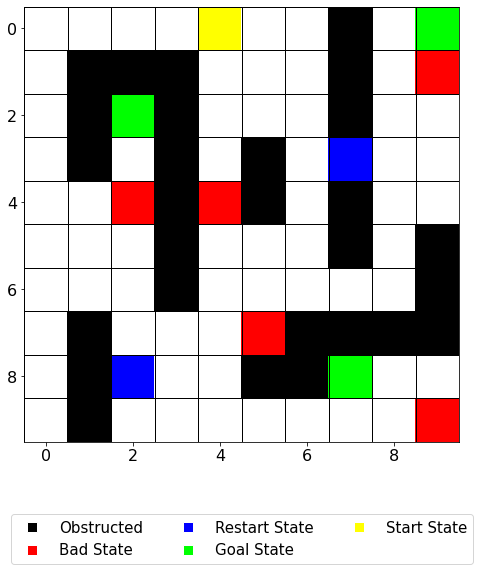

In [33]:
# Visualize the environment
plot = Plot(env, rewards=None, steps=None, state_visits=None, Q=None, save=True, exp="environment")

plot.visualize_grid_world()

In [37]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'sarsa', alphas, gammas, epsilons, taus, policy='softmax')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

Best alpha: 0.2
Best gamma: 0.95
Best epsilon: None
Best tau: 0.05
Best policy: softmax


Run:5: 100%|██████████| 5000/5000 [00:09<00:00, 506.33it/s]


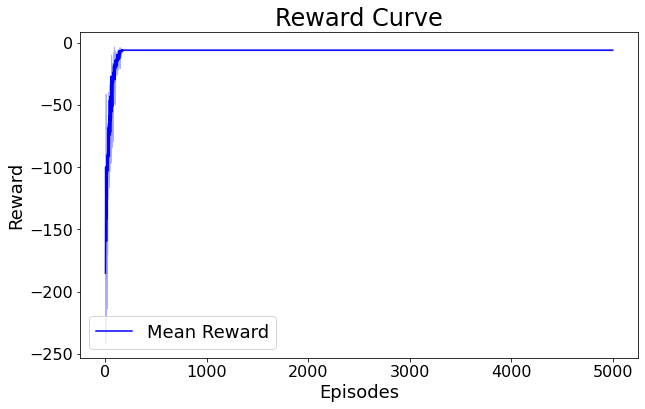

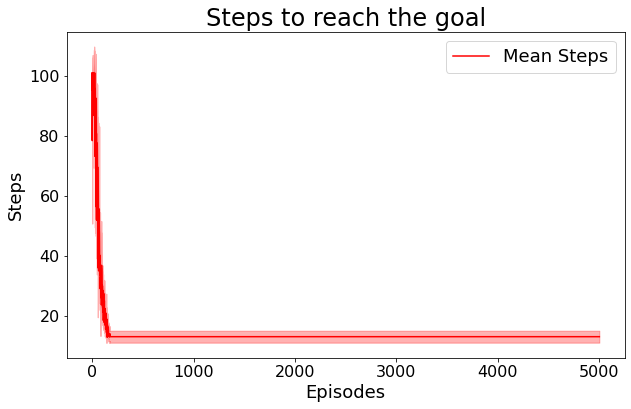

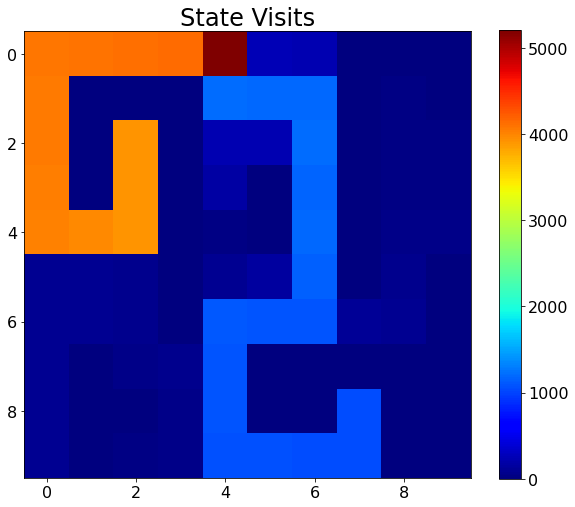

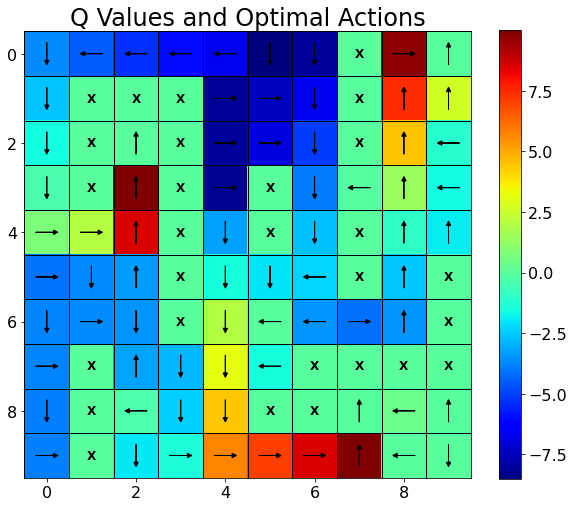

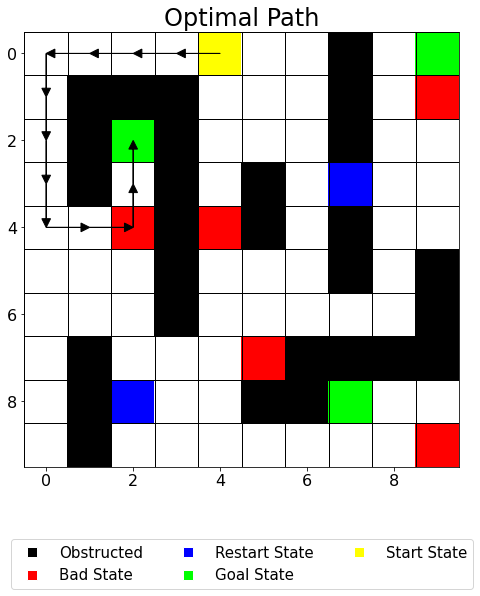

Path Taken: [4, 3, 2, 1, 0, 10, 20, 30, 40, 41, 42, 32, 22]
Total Reward [-6.]


In [36]:
# Softmax
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/1.1.1.1")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/1.1.1.1")

plot.reward()
plot.steps_to_goal()

#### Start state: (0, 4); Algorithm: SARSA; Policy: $\epsilon - $ greedy

In [ ]:
"""
Experiment 1.1.1.2:
wind=False (clear); p = 1.0 (deterministic step); Start state: (0, 4); Algorithm: SARSA; Policy: epsilon-greedy
"""

env = init_env(start_state=[0, 4], p_good_transition=1.0, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'sarsa', alphas, gammas, epsilons, taus, policy='epsilon_greedy')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Epsilon-greedy
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='epsilon_greedy')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/1.1.1.2")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='epsilon_greedy')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/1.1.1.2")

plot.reward()
plot.steps_to_goal()

#### Start state: (0, 4); Algorithm: Q-Learning; Policy: Softmax

In [ ]:
"""
Experiment 1.1.2.1:
wind=False (clear); p = 1.0 (deterministic step); Start state: (0, 4); Algorithm: Q-Learning; Policy: Softmax
"""

env = init_env(start_state=[0, 4], p_good_transition=1.0, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'qlearning', alphas, gammas, epsilons, taus, policy='softmax')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Softmax
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/1.1.2.1")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/1.1.2.1")

plot.reward()
plot.steps_to_goal()

#### Start state: (0, 4); Algorithm: Q-Learning; Policy: $\epsilon - $ greedy

In [ ]:
"""
Experiment 1.1.2.2:
wind=False (clear); p = 1.0 (deterministic step); Start state: (0, 4); Algorithm: Q-Learning; Policy: epsilon-greedy
"""

env = init_env(start_state=[0, 4], p_good_transition=1.0, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'qlearning', alphas, gammas, epsilons, taus, policy='epsilon_greedy')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Epsilon-greedy
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='epsilon-greedy')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/1.1.2.2")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='epsilon-greedy')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/1.1.2.2")

plot.reward()
plot.steps_to_goal()

#### Start state: (3, 6); Algorithm: SARSA; Policy: Softmax

In [ ]:
"""
Experiment 1.2.1.1:
wind=False (clear), p = 1.0 (deterministic step); Start state: (3, 6); Algorithm: SARSA; Policy: Softmax
"""

env = init_env(start_state=[3, 6], p_good_transition=1.0, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'sarsa', alphas, gammas, epsilons, taus, policy='softmax')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Softmax
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/1.2.1.1")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/1.2.1.1")

plot.reward()
plot.steps_to_goal()

#### Start state: (3, 6); Algorithm: SARSA; Policy: $\epsilon - $ greedy

In [ ]:
"""
Experiment 1.2.1.2:
wind=False (clear), p = 1.0 (deterministic step); Start state: (3, 6); Algorithm: SARSA; Policy: epsilon-greedy
"""

env = init_env(start_state=[3, 6], p_good_transition=1.0, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'sarsa', alphas, gammas, epsilons, taus, policy='epsilon_greedy')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Epsilon-greedy
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='epsilon-greedy')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/1.2.1.2")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='epsilon-greedy')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/1.2.1.2")

plot.reward()
plot.steps_to_goal()

#### Start state: (3, 6); Algorithm: Q-Learning; Policy: Softmax

In [ ]:
"""
Experiment 1.2.2.1:
wind=False (clear), p = 1.0 (deterministic step); Start state: (3, 6); Algorithm: Q-Learning; Policy: Softmax
"""

env = init_env(start_state=[3, 6], p_good_transition=1.0, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'qlearning', alphas, gammas, epsilons, taus, policy='softmax')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Softmax
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/1.2.2.1")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/1.2.2.1")

plot.reward()
plot.steps_to_goal()

#### Start state: (3, 6); Algorithm: Q-Learning; Policy: $\epsilon -$ greedy

In [ ]:
"""
Experiment 1.2.2.2:
wind=False (clear); p = 1.0 (deterministic step); Start state: (3, 6); Algorithm: Q-Learning; Policy: epsilon-greedy
"""

env = init_env(start_state=[3, 6], p_good_transition=1.0, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'qlearning', alphas, gammas, epsilons, taus, policy='epsilon_greedy')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Epsilon-greedy
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='epsilon_greedy')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/1.2.2.2")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

# Epsilon-greedy
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='epsilon_greedy')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/1.2.2.2")

plot.reward()
plot.steps_to_goal()

### Stochasticity Variant 2: `wind=False` (clear); `p = 0.7`(stochastic step)

#### Start state: (0, 4); Algorithm: SARSA; Policy: Softmax

In [ ]:
"""
Experiment 2.1.1.1:
wind=False (clear), p = 0.7 (stochastic step); Start state: (0, 4); Algorithm: SARSA; Policy: Softmax
"""

env = init_env(start_state=[0, 4], p_good_transition=0.7, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'sarsa', alphas, gammas, epsilons, taus, policy='softmax')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Softmax
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/2.1.1.1")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/2.1.1.1")

plot.reward()
plot.steps_to_goal()

#### Start state: (0, 4); Algorithm: SARSA; Policy: $\epsilon -$ greedy

In [ ]:
"""
Experiment 2.1.1.2:
wind=False (clear); p = 0.7 (stochastic step); Start state: (0, 4); Algorithm: SARSA; Policy: epsilon-greedy
"""

env = init_env(start_state=[0, 4], p_good_transition=0.7, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'sarsa', alphas, gammas, epsilons, taus, policy='epsilon-greedy')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Epsilon-greedy
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='epsilon_greedy')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/2.1.1.2")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

# Epsilon-greedy
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='epsilon_greedy')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/2.1.1.2")

plot.reward()
plot.steps_to_goal()

#### Start state: (0, 4); Algorithm: Q-Learning; Policy: Softmax

In [ ]:
"""
Experiment 2.1.2.1:
wind=False (clear); p = 0.7 (stochastic step); Start state: (0, 4); Algorithm: Q-Learning; Policy: Softmax
"""

env = init_env(start_state=[0, 4], p_good_transition=0.7, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'qlearning', alphas, gammas, epsilons, taus, policy='softmax')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Softmax
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/2.1.2.1")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/2.1.2.1")

plot.reward()
plot.steps_to_goal()

#### Start state: (0, 4); Algorithm: Q-Learning; Policy: $\epsilon - $ greedy

In [ ]:
"""
Experiment 2.1.2.2:
wind=False (clear); p = 0.7 (stochastic step); Start state: (0, 4); Algorithm: Q-Learning; Policy: epsilon-greedy
"""

env = init_env(start_state=[0, 4], p_good_transition=0.7, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'qlearning', alphas, gammas, epsilons, taus, policy='epsilon_greedy')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Epsilon-greedy
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='epsilon-greedy')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/2.1.2.2")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='epsilon-greedy')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/2.1.2.2")

plot.reward()
plot.steps_to_goal()

#### Start state: (3, 6); Algorithm: SARSA; Policy: Softmax

In [ ]:
"""
Experiment 2.2.1.1:
wind=False (clear), p = 0.7 (stochastic step); Start state: (3, 6); Algorithm: SARSA; Policy: Softmax
"""

env = init_env(start_state=[3, 6], p_good_transition=0.7, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'sarsa', alphas, gammas, epsilons, taus, policy='softmax')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Softmax
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/2.2.1.1")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/2.2.1.1")

plot.reward()
plot.steps_to_goal()

#### Start state: (3, 6); Algorithm: SARSA; Policy: $\epsilon - $ greedy

In [ ]:
"""
Experiment 2.2.1.2:
wind=False (clear), p = 0.7 (stochastic step); Start state: (3, 6); Algorithm: SARSA; Policy: epsilon-greedy
"""

env = init_env(start_state=[3, 6], p_good_transition=0.7, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'sarsa', alphas, gammas, epsilons, taus, policy='epsilon_greedy')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Epsilon-greedy
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='epsilon-greedy')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/2.2.1.2")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='epsilon-greedy')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/2.2.1.2")

plot.reward()
plot.steps_to_goal()

#### Start state: (3, 6); Algorithm: Q-Learning; Policy: Softmax

In [ ]:
"""
Experiment 2.2.2.1:
wind=False (clear), p = 0.7 (stochastic step); Start state: (3, 6); Algorithm: Q-Learning; Policy: Softmax
"""

env = init_env(start_state=[3, 6], p_good_transition=0.7, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'qlearning', alphas, gammas, epsilons, taus, policy='softmax')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Softmax
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/2.2.2.1")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

# Softmax
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/2.2.2.1")

plot.reward()
plot.steps_to_goal()

#### Start state: (3, 6); Algorithm: Q-Learning; Policy: $\epsilon -$ greedy

In [ ]:
"""
Experiment 2.2.2.2:
wind=False (clear); p = 0.7 (stochastic step); Start state: (3, 6); Algorithm: Q-Learning; Policy: epsilon-greedy
"""

env = init_env(start_state=[3, 6], p_good_transition=0.7, bias=0.5, wind=False)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'qlearning', alphas, gammas, epsilons, taus, policy='epsilon_greedy')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Epsilon-greedy
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='epsilon_greedy')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/2.2.2.2")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='epsilon_greedy')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/2.2.2.2")

plot.reward()
plot.steps_to_goal()

### Stochasticity Variant 3: `wind=True` (windy); `p = 1.0`(deterministic step)

#### Start state: (0, 4); Algorithm: SARSA; Policy: Softmax

In [ ]:
"""
Experiment 3.1.1.1:
wind=True (windy), p = 1.0 (deterministic step); Start state: (0, 4); Algorithm: SARSA; Policy: Softmax
"""

env = init_env(start_state=[0, 4], p_good_transition=1.0, bias=0.5, wind=True)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'sarsa', alphas, gammas, epsilons, taus, policy='softmax')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Softmax
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/3.1.1.1")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/3.1.1.1")

plot.reward()
plot.steps_to_goal()

#### Start state: (0, 4); Algorithm: SARSA; Policy: $\epsilon - $ greedy

In [ ]:
"""
Experiment 3.1.1.2:
wind=True (windy); p = 1.0 (deterministic step); Start state: (0, 4); Algorithm: SARSA; Policy: epsilon-greedy
"""

env = init_env(start_state=[0, 4], p_good_transition=1.0, bias=0.5, wind=True)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'sarsa', alphas, gammas, epsilons, taus, policy='epsilon-greedy')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Epsilon-greedy
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='epsilon_greedy')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/3.1.1.2")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='epsilon_greedy')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/3.1.1.2")

plot.reward()
plot.steps_to_goal()

#### Start state: (0, 4); Algorithm: Q-Learning; Policy: Softmax

In [ ]:
"""
Experiment 3.1.2.1:
wind=True (windy); p = 1.0 (deterministic step); Start state: (0, 4); Algorithm: Q-Learning; Policy: Softmax
"""

env = init_env(start_state=[0, 4], p_good_transition=1.0, bias=0.5, wind=True)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'qlearning', alphas, gammas, epsilons, taus, policy='softmax')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Softmax
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/3.1.2.1")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/3.1.2.1")

plot.reward()
plot.steps_to_goal()

#### Start state: (0, 4); Algorithm: Q-Learning; Policy: $\epsilon - $ greedy

In [ ]:
"""
Experiment 3.1.2.2:
wind=True (windy); p = 1.0 (deterministic step); Start state: (0, 4); Algorithm: Q-Learning; Policy: epsilon-greedy
"""

env = init_env(start_state=[0, 4], p_good_transition=1.0, bias=0.5, wind=True)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'qlearning', alphas, gammas, epsilons, taus, policy='epsilon_greedy')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Epsilon-greedy
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='epsilon-greedy')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/3.1.2.2")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='epsilon-greedy')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/3.1.2.2")

plot.reward()
plot.steps_to_goal()

#### Start state: (3, 6); Algorithm: SARSA; Policy: Softmax

In [ ]:
"""
Experiment 3.2.1.1:
wind=True (windy), p = 1.0 (deterministic step); Start state: (3, 6); Algorithm: SARSA; Policy: Softmax
"""

env = init_env(start_state=[3, 6], p_good_transition=1.0, bias=0.5, wind=True)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'sarsa', alphas, gammas, epsilons, taus, policy='softmax')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Softmax
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/3.2.1.1")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/3.2.1.1")

plot.reward()
plot.steps_to_goal()

#### Start state: (3, 6); Algorithm: SARSA; Policy: $\epsilon - $ greedy

In [ ]:
"""
Experiment 3.2.1.2:
wind=True (windy), p = 1.0 (deterministic step); Start state: (3, 6); Algorithm: SARSA; Policy: epsilon-greedy
"""

env = init_env(start_state=[3, 6], p_good_transition=1.0, bias=0.5, wind=True)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'sarsa', alphas, gammas, epsilons, taus, policy='epsilon_greedy')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Epsilon-greedy
sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='epsilon-greedy')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/3.2.1.2")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

sarsa = SARSA(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='epsilon-greedy')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/3.2.1.2")

plot.reward()
plot.steps_to_goal()

#### Start state: (3, 6); Algorithm: Q-Learning; Policy: Softmax

In [ ]:
"""
Experiment 3.2.2.1:
wind=True (windy), p = 1.0 (deterministic step); Start state: (3, 6); Algorithm: Q-Learning; Policy: Softmax
"""

env = init_env(start_state=[3, 6], p_good_transition=1.0, bias=0.5, wind=True)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'qlearning', alphas, gammas, epsilons, taus, policy='softmax')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Softmax
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/3.2.2.1")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=num_runs, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/3.2.2.1")

plot.reward()
plot.steps_to_goal()

#### Start state: (3, 6); Algorithm: Q-Learning; Policy: $\epsilon -$ greedy

In [ ]:
"""
Experiment 3.2.2.2:
wind=True (windy); p = 1.0 (deterministic step); Start state: (3, 6); Algorithm: Q-Learning; Policy: epsilon-greedy
"""

env = init_env(start_state=[3, 6], p_good_transition=1.0, bias=0.5, wind=True)

alpha = None
gamma = None
tau = None
epsilon = None

In [ ]:
# Hyperparameter tuning
best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'qlearning', alphas, gammas, epsilons, taus, policy='epsilon_greedy')

clear_output(wait=True)
time.sleep(0.3)

print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

In [ ]:
# Epsilon-greedy
q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=num_episodes, num_runs=num_runs, policy='epsilon_greedy')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="5K-episodes/3.2.2.2")

plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
"""
Experiment for 100 episodes
Objective: To understand the initial learning
"""

q_learning = QLearning(env=env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, tau=best_tau, num_episodes=100, num_runs=100, policy='epsilon_greedy')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="100-episodes/3.2.2.2")

plot.reward()
plot.steps_to_goal()